# Experimenting with memory efficient experience replay for Streaming Learning

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from continualai.colab.scripts import mnist
mnist.init()

Files already downloaded!
Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\mnist\MNIST\raw\train-images-idx3-ubyte.gz to data\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\mnist\MNIST\raw\train-labels-idx1-ubyte.gz to data\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to data\mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\mnist\MNIST\raw



In [5]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


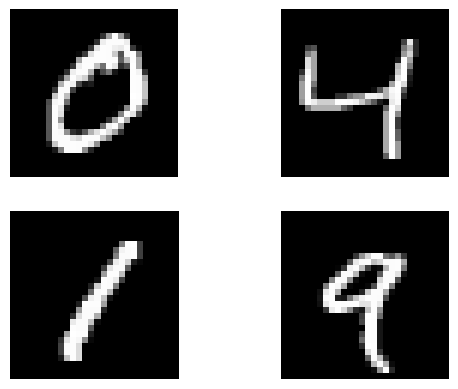

In [6]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [7]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1); # Sets the seed for generating random numbers on all devices. Returns a torch.Generator object.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1 input channel. Outputs 10 channels of 24x24 images (28 (pixels) - 5(kernel) + 1 (stride)) = 24
                                                     # Max pooling of 2x2 reduces the size to 12x12
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10 input channels. Outputs 20 channels of 8x8 images (12 - 5 + 1) = 8
                                                        # Max pooling of 2x2 reduces the size to 4x4    
        self.conv2_drop = nn.Dropout2d() # A 2D dropout layer which zeros out entire channels of an input feature map.
        self.fc1 = nn.Linear(320, 50) # 320 = 20 * 4 * 4
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [9]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
model.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)>

In [12]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [13]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [14]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [ ]:
# Plan: Use a buffer to store a small amount of data from the previous task.
#       This buffer will be used to train the model on the current task.
#       The buffer will be updated with new data from the current task.
#       The model will be trained on the current task and the buffer.
#       This process will be repeated for all tasks.
#       We will have k class-specific buffers, one for each class.
#       Each buffer will store at most c samples.
#       When a buffer is full, the oldest sample will be removed.

